In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_rel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Indlæs HR_data.csv
file_path = "C:\\Users\\david\\OneDrive\\Skrivebord\\DTU- 2. Semestre\\02445 Projekt i statistisk evaluering for Kunstig intelligens og Data\\HR_data.csv"
df = pd.read_csv(file_path)

# Vis de første rækker og kolonnenavne
print(df.describe())
print(df.head())

       Unnamed: 0     HR_Mean   HR_Median      HR_std      HR_Min      HR_Max  \
count  168.000000  168.000000  168.000000  168.000000  168.000000  168.000000   
mean    83.500000   76.009226   74.821458    6.041234   67.422679   89.062024   
std     48.641546    7.501301    8.101459    4.267282    7.042010   12.764559   
min      0.000000   57.341463   54.130000    0.844255   52.180000   70.150000   
25%     41.750000   70.952240   70.175000    3.092851   62.645000   79.752500   
50%     83.500000   75.618503   74.625000    4.678773   67.540000   87.355000   
75%    125.250000   80.308459   79.010000    7.281001   71.922500   94.682500   
max    167.000000   96.159341   94.880000   21.880307   82.680000  137.670000   

             HR_AUC  Individual     Puzzler  Frustrated  
count    168.000000   168.00000  168.000000  168.000000  
mean   23398.551815     7.50000    0.500000    2.291667  
std     3589.600223     4.04318    0.501495    1.924796  
min    15975.450000     1.00000    0.0

In [22]:
# Funktioner og target
features = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']
target = 'Frustrated'

# Standardiser data
X = df[features]
y = df[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled['Individual'] = df['Individual']
df_scaled['Cohort'] = df['Cohort']
df_scaled['Frustrated'] = y

# LOSOCV
individuals = df_scaled['Individual'].unique()
rf_mae_list, dt_mae_list = [], []
rf_preds, dt_preds, y_true = [], [], []
cohort_mae = {'D1_1': {'rf': [], 'dt': []}, 'D1_2': {'rf': [], 'dt': []}}

for ind in individuals:
    train = df_scaled[df_scaled['Individual'] != ind]
    test = df_scaled[df_scaled['Individual'] == ind]

    X_train, y_train = train[features], train['Frustrated']
    X_test, y_test = test[features], test['Frustrated']

    rf = RandomForestRegressor(n_estimators=100, min_samples_split=5, random_state=42)
    dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=3, random_state=42)

    rf.fit(X_train, y_train)
    dt.fit(X_train, y_train)

    rf_pred = rf.predict(X_test)
    dt_pred = dt.predict(X_test)

    rf_mae = mean_absolute_error(y_test, rf_pred)
    dt_mae = mean_absolute_error(y_test, dt_pred)

    rf_mae_list.append(rf_mae)
    dt_mae_list.append(dt_mae)

    rf_preds.extend(rf_pred)
    dt_preds.extend(dt_pred)
    y_true.extend(y_test)

    # Gem kohort-specifik MAE
    cohort = test['Cohort'].values[0]
    cohort_mae[cohort]['rf'].append(rf_mae)
    cohort_mae[cohort]['dt'].append(dt_mae)

# Udregn samlet metrics
rf_mae_array = np.array(rf_mae_list)
dt_mae_array = np.array(dt_mae_list)
rf_rmse = np.sqrt(mean_squared_error(y_true, rf_preds))
dt_rmse = np.sqrt(mean_squared_error(y_true, dt_preds))
rf_r2 = r2_score(y_true, rf_preds)
dt_r2 = r2_score(y_true, dt_preds)

# p-værdier
mae_p = ttest_rel(rf_mae_array, dt_mae_array).pvalue

# Gennemsnit ± std
metrics_summary = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R²'],
    'Random Forest': [f"{rf_mae_array.mean():.2f} ± {rf_mae_array.std():.2f}",
                      f"{rf_rmse:.2f}", f"{rf_r2:.2f}"],
    'Decision Tree': [f"{dt_mae_array.mean():.2f} ± {dt_mae_array.std():.2f}",
                      f"{dt_rmse:.2f}", f"{dt_r2:.2f}"],
    'p-value': [f"{mae_p:.4f}", '—', '—']
})

metrics_summary


,Metric,Random Forest,Decision Tree,p-value
0,MAE,1.73 ± 0.49,1.83 ± 0.46,0.1311
1,RMSE,2.08,2.25,—
2,R²,-0.18,-0.37,—


C:\Users\david\AppData\Local\Temp\ipykernel_16532\2282210394.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rf_mae_array, dt_mae_array], labels=['Random Forest', 'Decision Tree'])


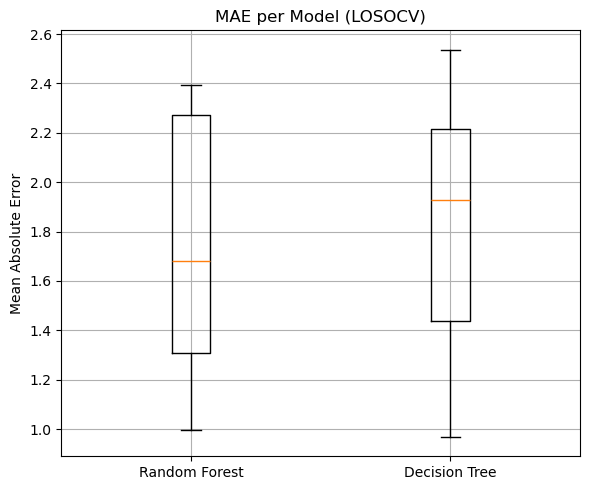

In [25]:
# Boxplot for MAE
plt.figure(figsize=(6, 5))
plt.boxplot([rf_mae_array, dt_mae_array], labels=['Random Forest', 'Decision Tree'])
plt.title("MAE per Model (LOSOCV)")
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()


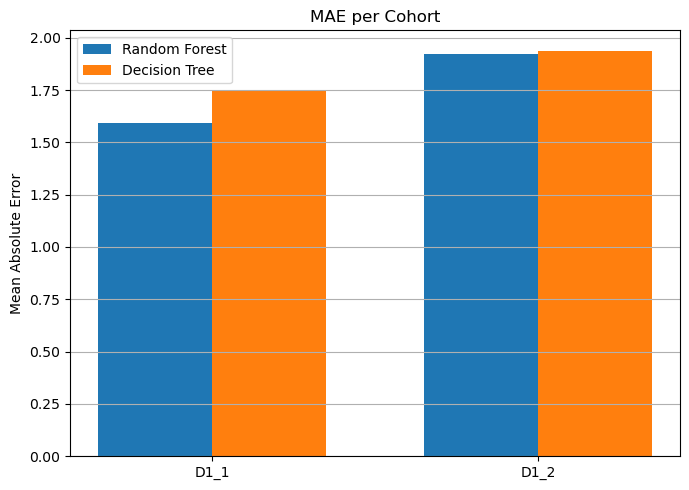

In [27]:
# Gennemsnitlig MAE pr. kohort
cohorts = ['D1_1', 'D1_2']
rf_mae_cohort = [np.mean(cohort_mae[c]['rf']) for c in cohorts]
dt_mae_cohort = [np.mean(cohort_mae[c]['dt']) for c in cohorts]

# Bar chart
x = np.arange(len(cohorts))
width = 0.35

plt.figure(figsize=(7, 5))
plt.bar(x - width/2, rf_mae_cohort, width, label='Random Forest')
plt.bar(x + width/2, dt_mae_cohort, width, label='Decision Tree')
plt.ylabel('Mean Absolute Error')
plt.title('MAE per Cohort')
plt.xticks(x, cohorts)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
